## Exploring Neural Networks using [Concrete Compressive Strength Set from UCI](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)

#### Analysis follows Chapter 7 of *Machine Learning with R* by Brett Lantz (though of course here we use Python, not R)

Objective:  Use a neural network to predict the compressive strength of concrete.

We'll first use the MLPRegressor function provided by scikit-learn, then use Keras to create a customized neural net.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline

from scipy.stats import pearsonr

warnings.filterwarnings("ignore")
%matplotlib

Using matplotlib backend: MacOSX


In [2]:
data = pd.read_excel('Concrete_Data.xls')

In [3]:
data.columns = ['Cement','Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 
                'Fine Aggregate', 'Age', 'Compressive Strength']

In [4]:
data.head(5)

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Compressive Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [5]:
data.shape

(1030, 9)

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Cement,1030.0,281.165631,104.507142,102.000000,192.375000,272.900000,350.000000,540.000000
Blast Furnace Slag,1030.0,73.895485,86.279104,0.000000,0.000000,22.000000,142.950000,359.400000
Fly Ash,1030.0,54.187136,63.996469,0.000000,0.000000,0.000000,118.270000,200.100000
Water,1030.0,181.566359,21.355567,121.750000,164.900000,185.000000,192.000000,247.000000
Superplasticizer,1030.0,6.203112,5.973492,0.000000,0.000000,6.350000,10.160000,32.200000
Coarse Aggregate,1030.0,972.918592,77.753818,801.000000,932.000000,968.000000,1029.400000,1145.000000
Fine Aggregate,1030.0,773.578883,80.175427,594.000000,730.950000,779.510000,824.000000,992.600000
Age,1030.0,45.662136,63.169912,1.000000,7.000000,28.000000,56.000000,365.000000
Compressive Strength,1030.0,35.817836,16.705679,2.331808,23.707115,34.442774,46.136287,82.599225


In [7]:
y = data['Compressive Strength']
X = data.drop(labels = ['Compressive Strength'], axis=1)

Ok, let's start by following the exercise in Lantz:
- scale the data to be in [0, 1]
- train the neural net with only 1 node (otherwise we'll use the default parameters)
- check the correlation between the predictions and the test data

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)
MMS = MinMaxScaler()
MMS.fit(X_train)
X_train = MMS.transform(X_train)
X_test = MMS.transform(X_test)

In [9]:
NN = MLPRegressor(hidden_layer_sizes=(1,))
NN.fit(X_train, y_train)
predictions = NN.predict(X_test)

In [10]:
NN.n_outputs_ 

1

In [11]:
print('correlation =', pearsonr(predictions, y_test)[0])

correlation = 0.407342952661


In [12]:
print('R2 score =',NN.score(X_test, y_test))

R2 score = -2.17568586835


Well, this net doesn't do a very good job.  Let's create a pipeline and try varying the parameters to find one that works:
- different scalers
- different # of nodes/layers
- different activation functions
- different algorithms
- different weights (alpha) for the l2 correction term

We'll use R2 score as the accuracy measure.  Correlation will be used as a sanity check.

In [13]:
#scaler to be used in the grid search
scaler_list = [
    ('mm', MinMaxScaler(), {})
    ,('std', StandardScaler(), {})

]
#parameters for the MLP regressor to be used in the grid search
classifier_list = [
    ('mlp', MLPRegressor(), {'mlp__hidden_layer_sizes': ((10,),(10, 10),(10, 10, 10), (30,),(30, 30),(30, 30, 30),
                                                        (50,),(50, 50),(50, 50, 50),(100,),(100, 100),(100, 100, 100)),        
    'mlp__activation':('logistic','relu','identity','tanh'),
     'mlp__solver':('lbfgs','sgd','adam'),
    'mlp__alpha':(1.0e-4,1.0e-3,1.0e-2,1.0e-1,1.0, 1.0e+1, 1.0e+2)})
]
results = {}

#loop over all scalers (2) and classifiers (only 1 here)
for s in scaler_list:
    for c in classifier_list:
        
        pipeline = Pipeline([ (s[0], s[1]), (c[0], c[1]) ])

        parameters = {}
        parameters.update(s[2])
        parameters.update(c[2])
        
        #do a grid search on the current scaler and classifier
        grid_search = GridSearchCV(pipeline, parameters, scoring='r2', verbose=0, n_jobs=4)

        results[(s[0], c[0])] = grid_search.fit(X_train,y_train)


In [14]:
print('Best R2 for MinMax scaling: ', results[('mm', 'mlp')].best_score_)

Best R2 for MinMax scaling:  0.86933232991


In [15]:
print('Best R2 for Z-scaling: ',results[('std', 'mlp')].best_score_)

Best R2 for Z-scaling:  0.882166511735


Much better.  Let's see which parameters give the best test scores.  First, MinMax scaling:

In [16]:
rdf = pd.DataFrame(results[('mm', 'mlp')].cv_results_)
rdf.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
927,0.455612,0.001282,0.869332,0.939832,tanh,1,"(100,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 1.0, 'm...",1,0.858329,0.944136,0.879283,0.931194,0.870432,0.944167,0.020130,0.000084,0.008593,0.006108
918,0.310932,0.000968,0.866853,0.928102,tanh,1,"(50,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 1.0, 'm...",2,0.851582,0.933849,0.876704,0.912742,0.872337,0.937716,0.011839,0.000075,0.010966,0.010976
282,1.547511,0.001588,0.864609,0.921997,relu,0.0001,"(100, 100)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 0.0001,...",3,0.844834,0.927067,0.878915,0.911406,0.870160,0.927517,0.006709,0.000040,0.014460,0.007491
156,0.363346,0.000927,0.863960,0.927748,logistic,1,"(30, 30)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 1.0, 'm...",4,0.831027,0.925701,0.883401,0.923687,0.877590,0.933857,0.003942,0.000008,0.023456,0.004397
909,0.219124,0.000825,0.861604,0.920326,tanh,1,"(30,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 1.0, 'm...",5,0.842356,0.924312,0.876408,0.906523,0.866127,0.930142,0.015505,0.000031,0.014269,0.010046


In [17]:
rdf = pd.DataFrame(results[('std', 'mlp')].cv_results_)
rdf.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
501,2.500739,0.001932,0.882167,0.971690,relu,100,"(100, 100, 100)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 100.0, ...",1,0.856028,0.971337,0.901952,0.974361,0.888629,0.969373,0.034118,0.000159,0.019302,0.002052
963,0.423166,0.001249,0.881758,0.968023,tanh,10,"(100,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 10.0, '...",2,0.859192,0.970434,0.891540,0.965678,0.894637,0.967958,0.015636,0.000079,0.016040,0.001942
483,0.509851,0.000998,0.881330,0.958858,relu,100,"(30, 30, 30)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 100.0, ...",3,0.857275,0.961008,0.891072,0.954082,0.895741,0.961484,0.016881,0.000025,0.017150,0.003383
954,0.322067,0.001043,0.879919,0.961848,tanh,10,"(50,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 10.0, '...",4,0.861349,0.966423,0.895001,0.959248,0.883485,0.959873,0.014220,0.000056,0.013972,0.003245
492,1.201638,0.001326,0.877526,0.966228,relu,100,"(50, 50, 50)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 100.0, ...",5,0.845841,0.970947,0.897508,0.963460,0.889360,0.964277,0.056364,0.000017,0.022696,0.003353


The highest scores are for Z-scaled data, the lbfgs algorithm, and the relu function with higher alpha.  Higher alphas seem to require more hidden layers, while lower alphas require fewer.  At the risk of overfitting, let's try to come up with even better values, using alphas between 1 and 100, and varying the number of nodes, keeping only one or 2 hidden layers.

In [18]:
scaler_list = [
    ('std', StandardScaler(), {})
]
classifier_list = [
    ('mlp', MLPRegressor(), {'mlp__hidden_layer_sizes': ((30,),(30, 30), (40,),(40, 40), (50,),(50, 50),
                                                        (60,),(60, 60),(70,),(70, 70),(80,), (80, 80),
                                                        (90,),(90, 90),(100,),(100, 100)),        
    'mlp__activation':('relu',),
    'mlp__solver':('lbfgs',),
    'mlp__alpha':(1, 5, 10, 20, 50, 100)})
]
results = {}

for s in scaler_list:
    for c in classifier_list:
        
        pipeline = Pipeline([ (s[0], s[1]), (c[0], c[1]) ])

        parameters = {}
        parameters.update(s[2])
        parameters.update(c[2])

        grid_search = GridSearchCV(pipeline, parameters, scoring='r2', verbose=0, n_jobs=4)

        results[(s[0], c[0])] = grid_search.fit(X_train,y_train)
    

In [19]:
rdf = pd.DataFrame(results[('std', 'mlp')].cv_results_)
rdf.sort_values(by='mean_test_score', ascending=False).head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_mlp__activation,param_mlp__alpha,param_mlp__hidden_layer_sizes,param_mlp__solver,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
69,0.612897,0.001081,0.881365,0.961319,relu,50,"(50, 50)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 50, 'ml...",1,0.851039,0.960029,0.905638,0.962458,0.887546,0.961471,0.007971,0.000007,0.022721,0.000997
47,1.908198,0.001661,0.880527,0.982358,relu,10,"(100, 100)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 10, 'ml...",2,0.844885,0.983387,0.893745,0.981364,0.903099,0.982323,0.025905,0.000272,0.025541,0.000826
14,0.367274,0.001179,0.880134,0.968935,relu,1,"(100,)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 1, 'mlp...",3,0.857414,0.969064,0.887441,0.970277,0.895641,0.967462,0.007989,0.000306,0.016442,0.001153
29,1.525953,0.001761,0.878272,0.980228,relu,5,"(90, 90)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 5, 'mlp...",4,0.842130,0.982050,0.903341,0.979508,0.889496,0.979125,0.090760,0.000406,0.026225,0.001298
77,1.547184,0.001456,0.878164,0.967602,relu,50,"(90, 90)",lbfgs,"{'mlp__solver': 'lbfgs', 'mlp__alpha': 50, 'ml...",5,0.848060,0.969957,0.888188,0.966420,0.898369,0.966430,0.040029,0.000011,0.021732,0.001665


The best values are alpha=50 and two hidden layers of 50 nodes each.  Let's see how this looks on the test data:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)
ZS = StandardScaler()
ZS.fit(X_train)
X_train = ZS.transform(X_train)
X_test = ZS.transform(X_test)
NN = MLPRegressor(hidden_layer_sizes=(50, 50), solver='lbfgs', alpha=50, activation='relu')
#NN = MLPRegressor(hidden_layer_sizes=(30,30), solver='lbfgs', alpha=10, activation='relu')
NN.fit(X_train, y_train)
predictions = NN.predict(X_test)
print('correlation =', pearsonr(predictions, y_test)[0])
print('R2 score =',NN.score(X_test, y_test))

correlation = 0.95795267284
R2 score = 0.917300471449


This is quite nice.  And visually, the points lie fairly close to the 45 degree line:

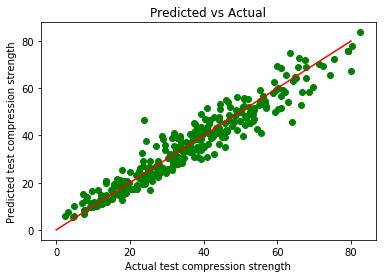

In [21]:
%matplotlib inline 
plt.scatter(y_test, predictions, marker='o', color='g')
plt.plot((0,80),(0,80), color='r')
plt.xlabel('Actual test compression strength')
plt.ylabel('Predicted test compression strength')
plt.title('Predicted vs Actual')
plt.show()

Next, let's try creating a neural net in Keras:

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K

Using TensorFlow backend.


In [23]:
#standard scaler had the best performance above, so let's just stick with that
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7234)
SS = StandardScaler()
SS.fit(X_train)
X_train = SS.transform(X_train)
X_test = SS.transform(X_test)

In [24]:
#customized metric - doesn't already exist ?!?
def r_squared(y_true, y_pred):
    ''' Customized loss function for R^2 
    y_true = Keras tensor of actual values
    y_pred = Keras tensor of predicted values
    
    '''
    mu = K.mean(y_true)
    tss = K.sum(K.square(y_true - mu)) #total sum of squares
    rss = K.sum(K.square(y_true - y_pred)) #residual sum of squares

    return (1 - rss/(K.epsilon() + tss))

#each hidden layer can be a different size
def nn_model(layers, activation, optimizer, input_shape, alpha=1):
    '''Neural net model of only dense layers

    layers: List of integers, the number of hidden units in each layer
    activation:  String, name of activation function used for each layer ('relu', etc.)
    optimizer:  String, name of optimization algorithm ('sgd', etc.)
    input_shape:  Sequence of integers, dimensions of the input layer
    '''

    model = Sequential()
   
    first_layer = True

    for layer in layers:
        #if 1st layer, need to specify input shape
        if first_layer:
            model.add(Dense(layer, input_shape = input_shape, kernel_regularizer=regularizers.l2(alpha)) )
            first_layer = False
        else:
            model.add(Dense(layer, kernel_regularizer=regularizers.l2(alpha)))

        model.add(Activation(activation))

    model.add(Dense(1))
    model.add(Activation('linear'))
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=[r_squared])

    return model

#each hidden layer is the same size
def nn_model_same_size(layer_size, no_layers, activation, optimizer, input_shape, alpha=1):
    '''Neural net model of only dense layers

    layer_size: Integer, the number of hidden units in each layer
    no_layers: Integer, the number of hidden layers
    activation:  String, name of activation function used for each layer ('relu', etc.)
    optimizer:  String, name of optimization algorithm ('sgd', etc.)
    input_shape:  Sequence of integers, dimensions of the input layer
    '''

    model = Sequential()

    for layer in range(no_layers):
        #if 1st layer, need to specify input shape
        if layer:
            model.add(Dense(layer_size, kernel_regularizer=regularizers.l2(alpha)))
        else:
            model.add(Dense(layer_size, input_shape = input_shape, kernel_regularizer=regularizers.l2(alpha)) )
            
        model.add(Activation(activation))

    model.add(Dense(1))
    model.add(Activation('linear'))
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=[r_squared])

    return model

Let's do a sanity check:

In [27]:
myModel = nn_model_same_size(50, 2, 'tanh', 'sgd', (X_train.shape[1],), alpha=0)
myModel.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)
myModel.evaluate(X_test, y_test)

309/309 [==============================] - 0s 100us/step


[31.176885783865227, 0.89062236967981823]

Ok, that's pretty close to the above result.  Let's set up a grid search.  

In [29]:
#Based on this post on using GridSearchCV with keras:
#    https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
keras_model = KerasRegressor(build_fn=nn_model_same_size, input_shape=(X_train.shape[1],), alpha=0)
layer_list = (10, 20, 30, 40, 50, 60, 70, 80, 90, 100)
layer_depth = (1, 2)

grid_search = GridSearchCV(keras_model
                         ,param_grid={'layer_size': layer_list
                                      ,'no_layers': layer_depth
                                     ,'activation': ('tanh',)
                                     ,'optimizer': ('sgd',)
                                     } 
                        ,scoring='r2'
                        
                        )
result = grid_search.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)

In [30]:
means = result.cv_results_['mean_train_score']
stds = result.cv_results_['std_train_score']
params = result.cv_results_['params']
#display results in order of mean r squared
for i in np.argsort(means)[::-1]:
   print('%f +/- %f with: %r' % (means[i], stds[i], params[i]))

0.961116 +/- 0.023201 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 2, 'layer_size': 100}
0.959955 +/- 0.006217 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 50}
0.958119 +/- 0.032429 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 2, 'layer_size': 80}
0.954299 +/- 0.023271 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 2, 'layer_size': 50}
0.953913 +/- 0.012453 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 100}
0.950023 +/- 0.023831 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 60}
0.946878 +/- 0.020900 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 2, 'layer_size': 20}
0.943221 +/- 0.028370 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 2, 'layer_size': 40}
0.940524 +/- 0.023282 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 90}
0.938671 +/- 0.035629 with: {'optimizer': 'sgd', 'act

So, the bigger the better.  Let's see the test scores:

In [31]:
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for i in np.argsort(means)[::-1]:
   print('%f +/- %f with: %r' % (means[i], stds[i], params[i]))

0.864078 +/- 0.023153 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 50}
0.859458 +/- 0.020838 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 100}
0.858371 +/- 0.024622 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 60}
0.856091 +/- 0.013983 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 90}
0.838957 +/- 0.018597 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 80}
0.837682 +/- 0.005423 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 2, 'layer_size': 100}
0.833136 +/- 0.039102 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 20}
0.830775 +/- 0.021695 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 70}
0.829430 +/- 0.011959 with: {'optimizer': 'sgd', 'activation': 'tanh', 'no_layers': 1, 'layer_size': 10}
0.829155 +/- 0.042371 with: {'optimizer': 'sgd', 'act

Ok, so maybe the larger networks are overfitting.  Let's use a single 50-unit hidden layer.

Next, try varying alpha to reduce overfitting:

In [32]:
keras_model = KerasRegressor(build_fn=nn_model_same_size, input_shape=(X_train.shape[1],))

alpha_list = (0, 0.0001, 0.001, 0.01, 0.1, 1)

grid_search = GridSearchCV(keras_model
                         ,param_grid={'layer_size': (50,)
                                      ,'no_layers': (1,)
                                     ,'activation': ('tanh', )
                                     ,'optimizer': ('sgd',)
                                    ,'alpha': alpha_list
                                     } 
                        ,scoring='r2'
                        
                        )
result = grid_search.fit(X_train, y_train, epochs=200, batch_size=32, verbose=0)

In [33]:
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']

for i in np.argsort(means)[::-1]:
   print('%f +/- %f with: %r' % (means[i], stds[i], params[i]))

0.862485 +/- 0.013195 with: {'alpha': 0.0001, 'activation': 'tanh', 'optimizer': 'sgd', 'no_layers': 1, 'layer_size': 50}
0.860817 +/- 0.019792 with: {'alpha': 0.001, 'activation': 'tanh', 'optimizer': 'sgd', 'no_layers': 1, 'layer_size': 50}
0.851777 +/- 0.018501 with: {'alpha': 0, 'activation': 'tanh', 'optimizer': 'sgd', 'no_layers': 1, 'layer_size': 50}
0.845669 +/- 0.009952 with: {'alpha': 0.01, 'activation': 'tanh', 'optimizer': 'sgd', 'no_layers': 1, 'layer_size': 50}
0.816843 +/- 0.052016 with: {'alpha': 0.1, 'activation': 'tanh', 'optimizer': 'sgd', 'no_layers': 1, 'layer_size': 50}
0.382342 +/- 0.189443 with: {'alpha': 1, 'activation': 'tanh', 'optimizer': 'sgd', 'no_layers': 1, 'layer_size': 50}


Well, the smallest values of alpha are within the errors of the best R squared value, so that doesn't seem any better.

Finally, let's try with the real test data:

In [34]:
grid_search.score(X_test, y_test)

0.89563490158806136

The best R squared value found using MLPRegressor was 0.9173.  